In [27]:
import requests
from pandas import DataFrame
from bs4 import BeautifulSoup
import re
from datetime import datetime
import os
import pandas as pd
import numpy as np

from konlpy.utils import pprint
from konlpy.tag import Kkma
from konlpy.tag import Okt
from collections import Counter


from PIL import Image

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib

In [28]:
date = str(datetime.now()) 
date = date[:date.rfind(':')].replace(' ', '_') 
date = date.replace(':','시') + '분' 

In [29]:
query = input('검색 키워드를 입력하세요 : ') 
query = query.replace(' ', '+') 

news_num = int(input('총 필요한 뉴스기사 수를 입력해주세요(숫자만 입력) : ')) 

검색 키워드를 입력하세요 : 연남동
총 필요한 뉴스기사 수를 입력해주세요(숫자만 입력) : 2000


In [30]:
news_url = 'https://search.naver.com/search.naver?where=news&sm=tab_jum&query={}'

req = requests.get(news_url.format(query))
soup = BeautifulSoup(req.text, 'html.parser')

In [31]:
news_dict = {} 
idx = 0 
cur_page = 1

In [32]:
print()
print('크롤링 중...')

while idx < news_num:
### 네이버 뉴스 웹페이지 구성이 바뀌어 태그명, class 속성 값 등을 수정함(20210126) ###
    
    table = soup.find('ul',{'class' : 'list_news'})
    li_list = table.find_all('li', {'id': re.compile('sp_nws.*')})
    area_list = [li.find('div', {'class' : 'news_area'}) for li in li_list]
    a_list = [area.find('a', {'class' : 'news_tit'}) for area in area_list]
    
    for n in a_list[:min(len(a_list), news_num-idx)]:
        news_dict[idx] = {'title' : n.get('title'),
                          'url' : n.get('href') }
        idx += 1

    cur_page += 1
    #print(news_dict[idx])
    pages = soup.find('div', {'class' : 'sc_page_inner'})
    next_page_url = [p for p in pages.find_all('a') if p.text == str(cur_page)][0].get('href')
    
    req = requests.get('https://search.naver.com/search.naver' + next_page_url)
    soup = BeautifulSoup(req.text, 'html.parser')


크롤링 중...


In [35]:
print('크롤링 완료')

print('데이터프레임 변환')
news_df = DataFrame(news_dict).T

folder_path = os.getcwd()
csv_file_name = '네이버뉴스_{}_{}.csv'.format(query, date)

news_df.to_csv(csv_file_name)

print('엑셀 저장 완료 | 경로 : {}\\{}'.format(folder_path, csv_file_name))
os.startfile(folder_path)

크롤링 완료
데이터프레임 변환
엑셀 저장 완료 | 경로 : C:\Users\고태영\Documents\GitHub\crawling\네이버뉴스_연남동_2021-07-23_01시20분.csv


# word clouding

## 파일 읽기

In [36]:
news_df = pd.read_csv('./네이버뉴스_연남동_2021-07-23_01시20분.csv')
news_df.drop(['Unnamed: 0'],axis=1, inplace=True)
news_df.to_csv('news_title.txt')
file = 'C:/Users/고태영/Documents/GitHub/crawling/news_title.txt'

### 전처리

### 한글 명사 추출

In [37]:
f = open(file, 'r', encoding = 'utf-8')
news = f.read()

# okt 객체 생성
okt = Okt()
noun = okt.nouns(news)
for i,v in enumerate(noun):
    if len(v)<2:
        noun.pop(i)
        
count = Counter(noun)

# 명사 빈도 카운트
noun_list = count.most_common(200)

## word cloud

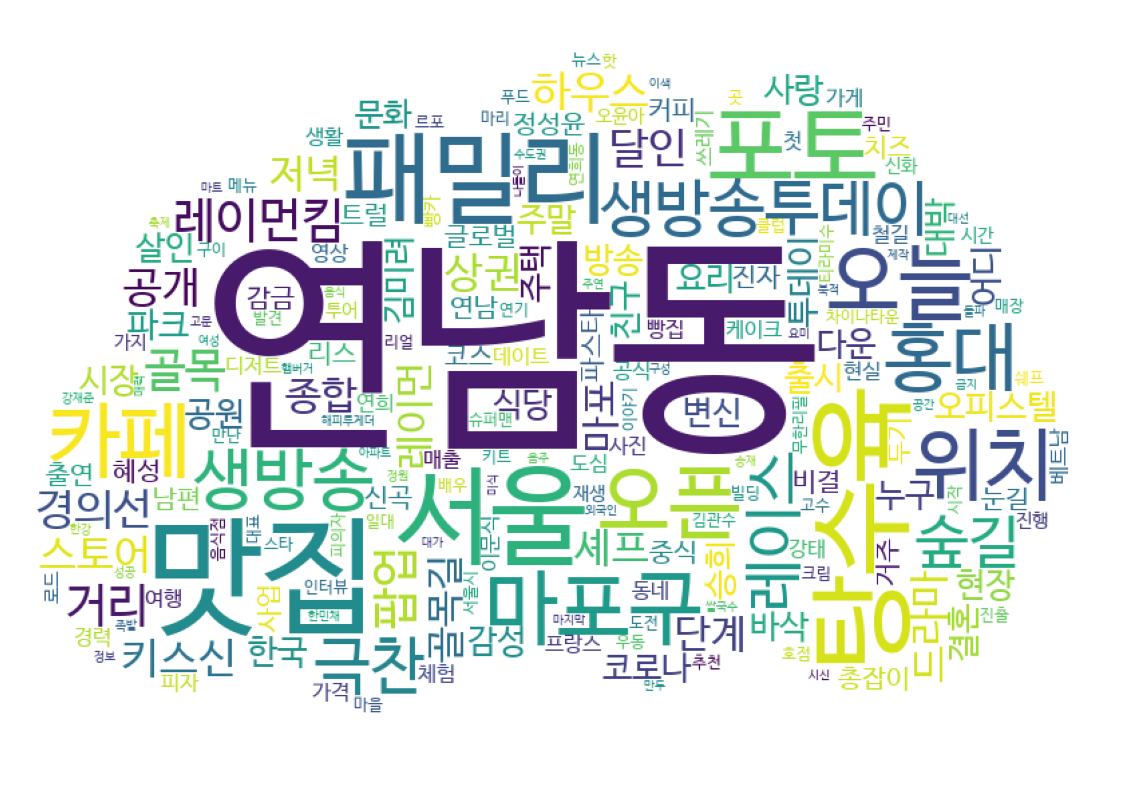

In [38]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
font_path = r'C:/Users/고태영/Downloads/NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'

denne_mask = np.array(Image.open('cloud_6.png'))

wc = WordCloud(font_path=font_path, background_color="white", width=800, height=600, mask = denne_mask)
cloud = wc.generate_from_frequencies(dict(noun_list))

plt.figure(figsize = (20,16))
plt.axis('off')
plt.imshow(cloud)
plt.savefig('wordcloud_yeonam_article')